In [356]:
import skimage.io as io
import pandas as pd
import os
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
import ast
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import radius_graph
import progressbar
from tqdm.notebook import tqdm


In [2]:
tiles_path = '/Users/akre96/Data/BE_223B/tiles_rois/normalized/'
centroids_path = '/Users/akre96/Data/BE_223B/tiles_rois/centroids/'
features_path = '/Users/akre96/Data/BE_223B/tiles_rois/nucleus_features/'
labels_path = '/Users/akre96/Data/BE_223B/tiles_rois/dataset.csv'
labels = pd.read_csv(labels_path)

In [350]:
tile_files = os.listdir(tiles_path)
tile_files = [tf for tf in tile_files if tf[0] != '.']


In [4]:
tile_id  = '7664_26880_36736'
#tile_id = tf.split('/')[-1].split('.')[0]
tile = io.imread(os.path.join(tiles_path, tile_id + '.png'))
centroid = pd.read_csv(os.path.join(centroids_path, tile_id + '.csv'))
features = pd.read_csv(os.path.join(features_path, tile_id + '.csv'), converters={"diagnostics_Mask-original_CenterOfMass": ast.literal_eval})
feature_cols = ['original_gldm_DependenceNonUniformity']
label = labels[labels.tile_name == tile_id].label.values

In [307]:
features[feature_cols_subset]

,diagnostics_Mask-original_VolumeNum,diagnostics_Mask-original_VoxelNum,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,...,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn
0,1,118,47.7,181.6,2005510.0,2.948999,66.00,2.479678,241.0,120.779661,...,-2.622010,14.107868,2.320755,0.717474,1.132075,1.880399,1.039160,0.581065,0.542319,0.974207
1,1,91,190.0,231.0,4221076.0,1.438210,19.50,2.936025,237.0,214.879121,...,-0.125531,1.419375,0.400000,0.560289,0.375000,1.023183,0.259375,0.816667,0.815000,0.961154
2,1,111,79.0,191.0,2261340.0,2.768939,60.00,2.405434,238.0,136.432432,...,1.063302,8.889900,3.290000,0.459766,1.390000,2.107815,1.357900,0.538167,0.485118,0.954827
3,1,65,11.4,62.8,101094.0,1.439624,16.00,10.500279,160.0,28.461538,...,16.759104,3.707769,0.490909,0.766160,0.345455,1.064384,0.371570,0.846970,0.841818,0.990716
4,1,122,22.1,113.6,625737.0,2.410160,38.00,6.694531,246.0,57.909836,...,36.269401,8.506860,1.266055,0.740905,0.605505,1.440790,0.899419,0.767584,0.754834,0.988619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1,56,63.0,188.0,785648.0,2.553499,60.75,3.329639,244.0,107.142857,...,59.855986,13.134450,2.170213,0.716398,1.021277,1.805863,1.127207,0.631915,0.601252,0.975531
396,1,85,32.0,168.0,909334.0,2.641540,88.00,2.893513,242.0,86.800000,...,69.464120,17.854167,0.972222,0.896717,0.638889,1.484154,0.564043,0.732639,0.713889,0.988494
397,1,29,65.8,235.2,808761.0,2.564757,142.00,1.341418,247.0,152.586207,...,32.490609,25.572314,3.772727,0.742871,1.409091,2.117350,1.787190,0.568939,0.512567,0.949558
398,1,109,58.4,224.4,2272700.0,3.158657,88.00,2.058102,241.0,131.669725,...,7.000439,18.242746,5.020619,0.568367,1.742268,2.352863,1.985121,0.490722,0.423506,0.955428


In [308]:
feat_rank = pd.read_csv('../PREPROCESSING/logistic_regression_coefficients.csv')
feat_rank = feat_rank.rename(columns={feat_rank.columns[0]:'feature'})
feat_rank['base_feat'] = feat_rank['feature'].str.split('_').str[:-1].str.join('_')
nuc_feat = pd.DataFrame(feat_rank.groupby('base_feat').abs_coef.max()).reset_index()
variable_cols = [
    col for col in features.columns 
    if ('diagnostics_Image-original' not in col) 
    and (col != 'diagnostics_Mask-original_VolumeNum')
]

nuc_feat = nuc_feat[nuc_feat.base_feat.isin(variable_cols)]
feature_cols_subset = nuc_feat.base_feat.tolist()[:32]

In [309]:
feature_cols_subset

['diagnostics_Mask-original_VoxelNum',
 'original_firstorder_10Percentile',
 'original_firstorder_90Percentile',
 'original_firstorder_Energy',
 'original_firstorder_Entropy',
 'original_firstorder_InterquartileRange',
 'original_firstorder_Kurtosis',
 'original_firstorder_Maximum',
 'original_firstorder_Mean',
 'original_firstorder_MeanAbsoluteDeviation',
 'original_firstorder_Median',
 'original_firstorder_Minimum',
 'original_firstorder_Range',
 'original_firstorder_RobustMeanAbsoluteDeviation',
 'original_firstorder_RootMeanSquared',
 'original_firstorder_Skewness',
 'original_firstorder_TotalEnergy',
 'original_firstorder_Uniformity',
 'original_firstorder_Variance',
 'original_glcm_Autocorrelation',
 'original_glcm_ClusterProminence',
 'original_glcm_ClusterShade',
 'original_glcm_ClusterTendency',
 'original_glcm_Contrast',
 'original_glcm_Correlation',
 'original_glcm_DifferenceAverage',
 'original_glcm_DifferenceEntropy',
 'original_glcm_DifferenceVariance',
 'original_glcm_Id

In [7]:
coordinates = torch.tensor(features['diagnostics_Mask-original_CenterOfMass'].tolist())
node_features = torch.tensor(features[feature_cols].values, dtype=torch.float32)
y = torch.tensor([label], dtype=torch.long)
data = Data(x = node_features, pos = coordinates, y = y, num_classes=2)
max_neighbours = 8
radius = 50
data.edge_index = radius_graph(data.pos, radius, None, True, max_neighbours)

In [312]:
data_sets = []
failed = []
for tf in tqdm(tile_files[:]):
    tile_id = tf.split('/')[-1].split('.')[0]
    tile = io.imread(os.path.join(tiles_path, tile_id + '.png'))
    centroid = pd.read_csv(os.path.join(centroids_path, tile_id + '.csv'))
    if os.path.isfile(os.path.join(features_path, tile_id + '.csv')):
        features = pd.read_csv(os.path.join(features_path, tile_id + '.csv'), converters={"diagnostics_Mask-original_CenterOfMass": ast.literal_eval})
    else:
        failed.append(tile_id)
        continue
    
    # Normalize Features
    f_df = features[feature_cols_subset]
    f_norm_df = (f_df - f_df.mean())/ (f_df.max() - f_df.min())
    coordinates = torch.tensor(features['diagnostics_Mask-original_CenterOfMass'].tolist())
    node_features = torch.tensor(f_norm_df.astype(float).values, dtype=torch.float32)
    
    # Create Label tensor
    label = labels[labels.tile_name == tile_id].label.values
    y = torch.tensor(label, dtype=torch.long)
    data = Data(x = node_features, pos = coordinates, y = y, num_classes=2)
    
    # Create Graph
    max_neighbours = 8
    radius = 50
    data.edge_index = radius_graph(data.pos, radius, None, True, max_neighbours)
    data_sets.append(data)


100% (1000 of 1000) |####################| Elapsed Time: 0:01:15 Time:  0:01:15


In [313]:
f_df.min() - f_df.max()

diagnostics_Mask-original_VoxelNum                -2.760000e+02
original_firstorder_10Percentile                  -2.109000e+02
original_firstorder_90Percentile                  -2.022000e+02
original_firstorder_Energy                        -1.065263e+07
original_firstorder_Entropy                       -3.286437e+00
original_firstorder_InterquartileRange            -1.807500e+02
original_firstorder_Kurtosis                      -1.157327e+01
original_firstorder_Maximum                       -2.070000e+02
original_firstorder_Mean                          -1.932857e+02
original_firstorder_MeanAbsoluteDeviation         -8.147362e+01
original_firstorder_Median                        -2.070000e+02
original_firstorder_Minimum                       -2.160000e+02
original_firstorder_Range                         -2.350000e+02
original_firstorder_RobustMeanAbsoluteDeviation   -7.045833e+01
original_firstorder_RootMeanSquared               -1.929701e+02
original_firstorder_Skewness            

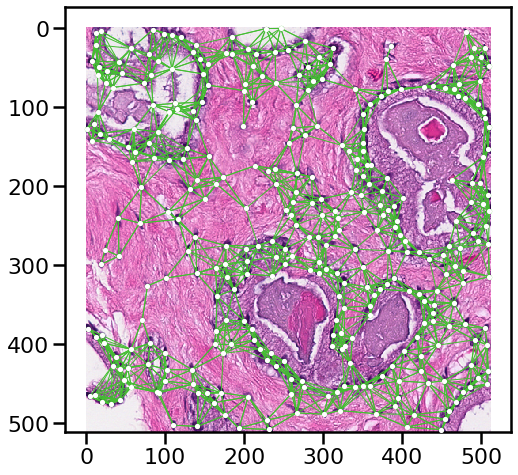

In [125]:
fig, ax = plt.subplots(figsize=(8,8))
data = data_sets[-1]
ax.imshow(tile)
color = '#44bd32'
ax.scatter(centroid['x'], centroid['y'], s=11, c=color)

for i, j in data.edge_index.T:
    x = [data.pos[i][1], data.pos[j][1]]
    y = [data.pos[i][0], data.pos[j][0]]
    ax.plot(x, y, c=color, lw=1, zorder=100)
ax.scatter(centroid['x'], centroid['y'], s=10, c='white', zorder=1000)

In [357]:
batch_size = 32
validation_pct = 0.1
validation_size = int(len(data_sets) * validation_pct)

train_set = data_sets[:-validation_size]
test_set = data_sets[-validation_size:]
print(len(train_set), len(test_set), validation_size)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
train_test_loader = DataLoader(train_set, batch_size=1, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)

891 99 99


In [412]:
import torch.nn.functional as F
import torch_geometric.nn as nn

from torch_geometric.nn import GCNConv, BatchNorm, SAGPooling, SAGEConv, GATConv
from torch.nn import Linear

class Net(torch.nn.Module):
    def __init__(self, in_feats):
        super(Net, self).__init__()
        
        hs_1 = in_feats * 2
        self.conv1 = SAGEConv(in_feats, hs_1)
        self.bn1 = BatchNorm(hs_1)
        self.pool1 = SAGPooling(hs_1, ratio=0.5)
        
        hs_2 = int(hs_1 * 4)
        self.conv2 = GATConv(hs_1, hs_2, dropout=.5)
        self.bn2 = BatchNorm(hs_2)
        self.pool2 = SAGPooling(hs_2, ratio=0.5)
        
        hs_3 = int(hs_2 * 4)
        self.conv3 = GATConv(hs_2, hs_3, dropout=0.5)
        self.bn3 = BatchNorm(hs_3)
        self.pool3 = SAGPooling(hs_3, ratio=0.5)
        
        num_classes = 2
        self.lin1 = Linear(hs_3, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x, edge_index, edge_attr, batch, perm, score = self.pool1(x, edge_index, batch=data.batch)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x, edge_index, edge_attr, batch, perm, score = self.pool2(x, edge_index, batch=batch)
        
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x, edge_index, edge_attr, batch, perm, score = self.pool3(x, edge_index, batch=batch)
        
        
        x = nn.global_mean_pool(x, batch)
        x = F.relu(x)
        x = self.lin1(x)

        return F.softmax(x, dim=1)

In [413]:
from tqdm.notebook import tqdm
epochs = 20

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_function = torch.nn.CrossEntropyLoss()
model = Net(len(feature_cols_subset)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
model.train()



for epoch in tqdm(range(epochs)):
    i = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = loss_function(out, batch.y)
        loss.backward()
        optimizer.step()
        if torch.isnan(loss):
            break
    print(loss.item())


0.5865689516067505
0.5806256532669067
0.512362539768219
0.5214937925338745
0.5444886684417725
0.5002099275588989
0.5418261289596558
0.46036529541015625
0.5754367113113403
0.6281773447990417
0.6102478504180908
0.534643828868866
0.5860564708709717
0.47847312688827515
0.42776933312416077
0.6374473571777344
0.4370653033256531
0.5567257404327393
0.5494760870933533
0.46400150656700134



In [409]:
loss

tensor(0.6436, grad_fn=<NllLossBackward>)

In [414]:
# Train Set
from sklearn.metrics import roc_auc_score, roc_curve
model.eval()
x=[]
y=[]
TP=0
FP=0
TN=0
FN=0

preds=[]
y_true=[]

for data in train_test_loader:
    mod_out = model(data)
    pred = torch.argmax(mod_out[0])
    
    truth = data.y[0]
    if pred == truth:
        if truth:
            TP+=1
        else:
            TN+=1
    else:
        if truth:
            FN+=1
        else:
            FP+=1
    x.append(truth.item())
    y.append(pred.item())
    preds.append(mod_out[0].tolist())
    y_true.append(np.eye(2)[truth])

total = TP+FP+FN+TN
print('Sensitivity:', TP/(TP+FN))
print('Specificity:', TN/(TN+FP))
print('Accuracy', (TP+TN)/(total))
print('AUC', roc_auc_score(y_true, preds))

Sensitivity: 0.9673202614379085
Specificity: 0.5949074074074074
Accuracy 0.7867564534231201
AUC 0.8733634914871298


In [415]:
# Test Set
from sklearn.metrics import roc_auc_score, roc_curve
model.eval()
x=[]
y=[]
TP=0
FP=0
TN=0
FN=0

preds=[]
y_true=[]

for data in test_loader:
    mod_out = model(data)
    pred = torch.argmax(mod_out[0])
    
    truth = data.y[0]
    if pred == truth:
        if truth:
            TP+=1
        else:
            TN+=1
    else:
        if truth:
            FN+=1
        else:
            FP+=1
    x.append(truth.item())
    y.append(pred.item())
    preds.append(mod_out[0].tolist())
    y_true.append(np.eye(2)[truth])

roc_auc_score(y_true, preds)
total = TP+FP+FN+TN
print('Sensitivity:', TP/(TP+FN))
print('Specificity:', TN/(TN+FP))
print('Accuracy', (TP+TN)/(total))
print('AUC', roc_auc_score(y_true, preds))

Sensitivity: 0.9473684210526315
Specificity: 0.5409836065573771
Accuracy 0.696969696969697
AUC 0.8731665228645384


## 10 Fold Cross Validation

In [ ]:
fold_cross = 10
epochs = 20
batch_size = 32
validation_pct = 0.1
validation_size = int(len(data_sets) * validation_pct)

performance_dict = {
    'TP': [],
    'TN': [],
    'FP': [],
    'FN': [],
    'total': [],
    'Accuracy': [],
    'Sensitivity': [],
    'Specificity': [],
    'AUC': []
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for i in tqdm(range(fold_cross)):
    print('\nFold:',i+1)
    test_set = data_sets[i*validation_size:(i+1)*validation_size]
    train_set = [t for t in data_sets if t not in test_set]
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=True)
    
    # Train
    loss_function = torch.nn.CrossEntropyLoss()
    model = Net(len(feature_cols_subset)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    model.train()



    for epoch in range(epochs):
        i = 0
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = loss_function(out, batch.y)
            loss.backward()
            optimizer.step()
            
    # Test
    model.eval()
    x=[]
    y=[]
    TP=0
    FP=0
    TN=0
    FN=0
    y_true=[]
    preds=[]
    for data in test_loader:
        mod_out = model(data)
        pred = torch.argmax(mod_out[0])
        truth = data.y[0]
        if pred == truth:
            if truth:
                TP+=1
            else:
                TN+=1
        else:
            if truth:
                FN+=1
            else:
                FP+=1
        x.append(truth.item())
        y.append(pred.item())
        preds.append(mod_out[0].tolist())
        y_true.append(np.eye(2)[truth])
    total = TP+FP+FN+TN
    Sensitivity = TP/(TP+FN)
    Specificity = TN/(TN+FP)
    Accuracy = (TP+TN)/(total)
    AUC = roc_auc_score(y_true, preds)
    print('Sensitivity:', Sensitivity)
    print('Specificity:', Specificity)
    print('Accuracy', Accuracy)
    print('Loss', loss.item())
    print('AUC', AUC)
    performance_dict['TP'].append(TP)
    performance_dict['TN'].append(TN)
    performance_dict['FP'].append(FP)
    performance_dict['FN'].append(FN)
    performance_dict['Sensitivity'].append(Sensitivity)
    performance_dict['Specificity'].append(Specificity)
    performance_dict['Accuracy'].append(Accuracy)
    performance_dict['total'].append(total)
    performance_dict['AUC'].append(AUC)


Fold: 1
Sensitivity: 0.78
Specificity: 0.6938775510204082
Accuracy 0.7373737373737373
Loss 0.5459474325180054
AUC 0.7738775510204081

Fold: 2
Sensitivity: 0.9038461538461539
Specificity: 0.6382978723404256
Accuracy 0.7777777777777778
Loss 0.5307608246803284
AUC 0.8846153846153846

Fold: 3
Sensitivity: 0.8431372549019608
Specificity: 0.4166666666666667
Accuracy 0.6363636363636364
Loss 0.6235640048980713
AUC 0.6830065359477124

Fold: 4


In [ ]:
perf_df = pd.DataFrame.from_dict(performance_dict)
perf_df[['Accuracy', 'Sensitivity', 'Specificity', 'AUC']] = perf_df[['Accuracy', 'Sensitivity', 'Specificity', 'AUC']] * 100

In [ ]:
fig, ax = plt.subplots(figsize=(9,8))
sns.set_context('poster')
perf_df['Fold'] = perf_df.index
melt_df = perf_df[['Fold', 'Accuracy', 'Sensitivity', 'Specificity', 'AUC']].melt(var_name='Metric', id_vars='Fold')
sns.swarmplot(
    x='Metric',
    y='value',
    hue='Fold',
    data=melt_df,
    ax=ax,
    s=10
)
ax.legend().remove()
ax.set_ylim((-5,105))
ax.set_xlabel('')
sns.despine()

In [ ]:
melt_df[['Metric', 'value']].groupby('Metric').describe()